In [1]:
import os

from skimage.io import imread
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from random import choice

from utils.datasets import get_yoga_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
yoga_classes = get_yoga_dataset()

Checking for yoga data in D:\Dropbox\Projects\clipsperiments\data\yoga.
Got 196 files for class Downdog.
Got 198 files for class Warrior2.
Got 198 files for class Tree.
Got 197 files for class Plank.
Got 199 files for class Goddess.


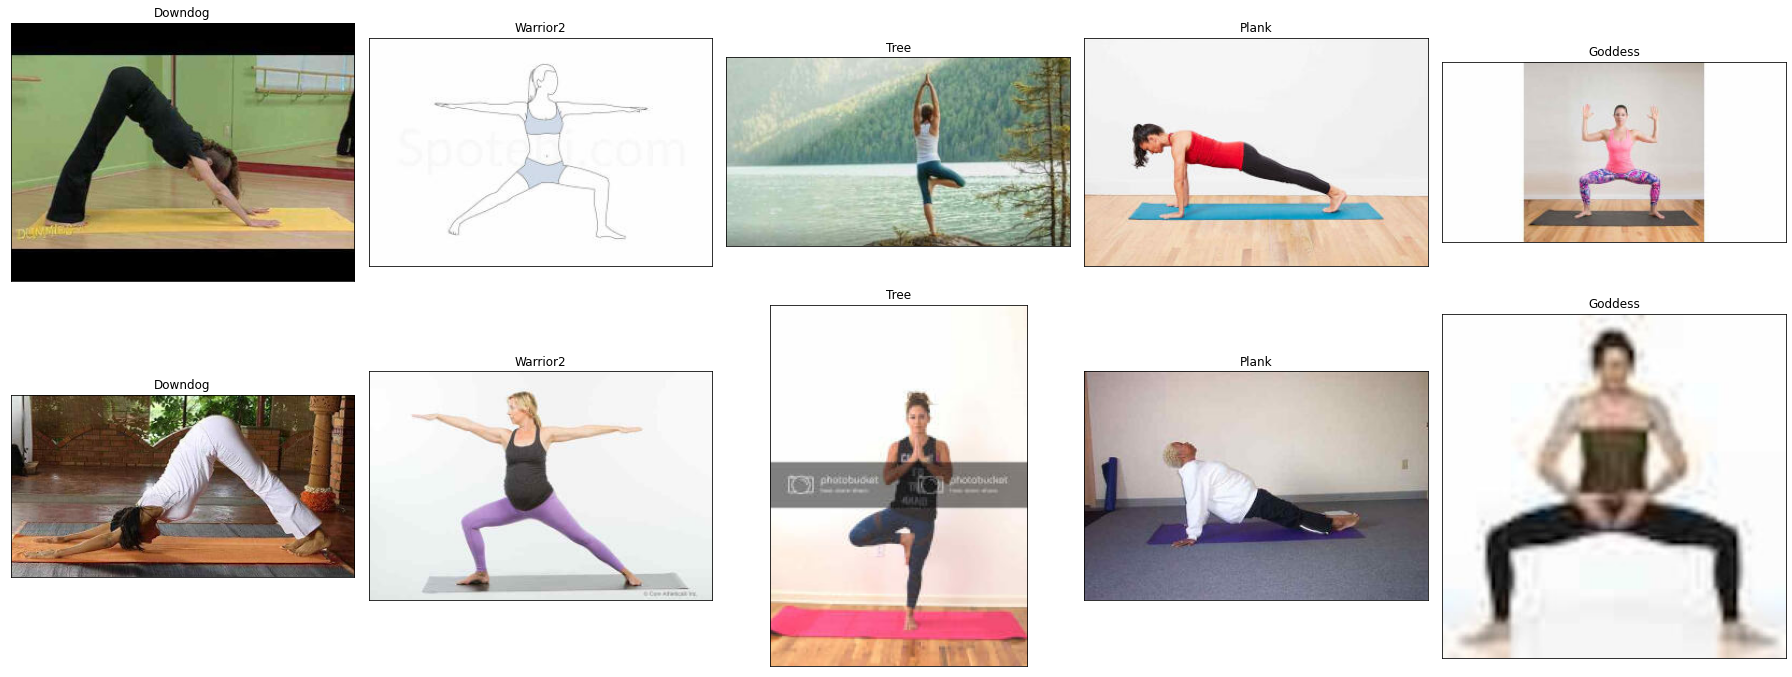

In [57]:
fig, axes = plt.subplots(2, len(yoga_classes), figsize=(25, 10))
for i, (cls, files) in enumerate(yoga_classes.items()):
    for j in range(2):
        first_image_path = choice(files)
        first_image = imread(first_image_path)
        axes[j][i].imshow(first_image)
        axes[j][i].set_title(cls)
        axes[j][i].axes.xaxis.set_visible(False)
        axes[j][i].axes.yaxis.set_visible(False)
fig.tight_layout()

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
processor.feature_extractor

CLIPFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 224
}

In [11]:
from utils.inference import evaluate_prompt_set_for_classes
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

prompt_set = [[ cls + " yoga pose" for cls in yoga_classes.keys()],
              ["downward dog yoga pose", "warrior two yoga pose", "tree yoga pose", "plank yoga pose", "goddess yoga pose"],
              ["Adho mukha svanasana", "Virabhadrasana II", "Vrikshasana", "Phalakasana", "Utkata Konasana"]]
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for idx, prompts in enumerate(prompt_set):
    preds, labels = evaluate_prompt_set_for_classes(model, processor, yoga_classes, prompts, device)
    recall = recall_score(labels, preds, average=None)
    precision = precision_score(labels, preds, average=None)
    accuracy = accuracy_score(labels, preds)
    print("Recall", recall)
    print("Precision", precision)
    ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(yoga_classes.keys()), ax=axes[idx], colorbar=False, cmap="inferno")
    axes[idx].set_title(f"Prompt set {idx}: Accuracy {accuracy:.2f}")
fig.tight_layout()

NameError: name 'yoga_classes' is not defined

In [10]:
prompt_set2 = [["a photo of a" + prompt for prompt in p] for p in prompt_set]
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for idx, prompts in enumerate(prompt_set2):
    preds, labels = evaluate_prompt_set_for_classes(model, processor, yoga_classes, prompts)
    recall = recall_score(labels, preds, average=None)
    precision = precision_score(labels, preds, average=None)
    accuracy = accuracy_score(labels, preds)
    print("Recall", recall)
    print("Precision", precision)
    ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(yoga_classes.keys()), ax=axes[idx], colorbar=False, cmap="inferno")
    axes[idx].set_title(f"Prompt set {idx}: Accuracy {accuracy:.2f}")
fig.tight_layout()

NameError: name 'prompt_set' is not defined

In [8]:
from utils.datasets import get_intel_scene_dataset

scene_classes = get_intel_scene_dataset(split="test")

Checking for scene data in D:\Dropbox\Projects\clipsperiments\data\intel.
Got 437 files for class buildings.
Got 510 files for class sea.
Got 501 files for class street.
Got 525 files for class mountain.
Got 553 files for class glacier.
Got 474 files for class forest.


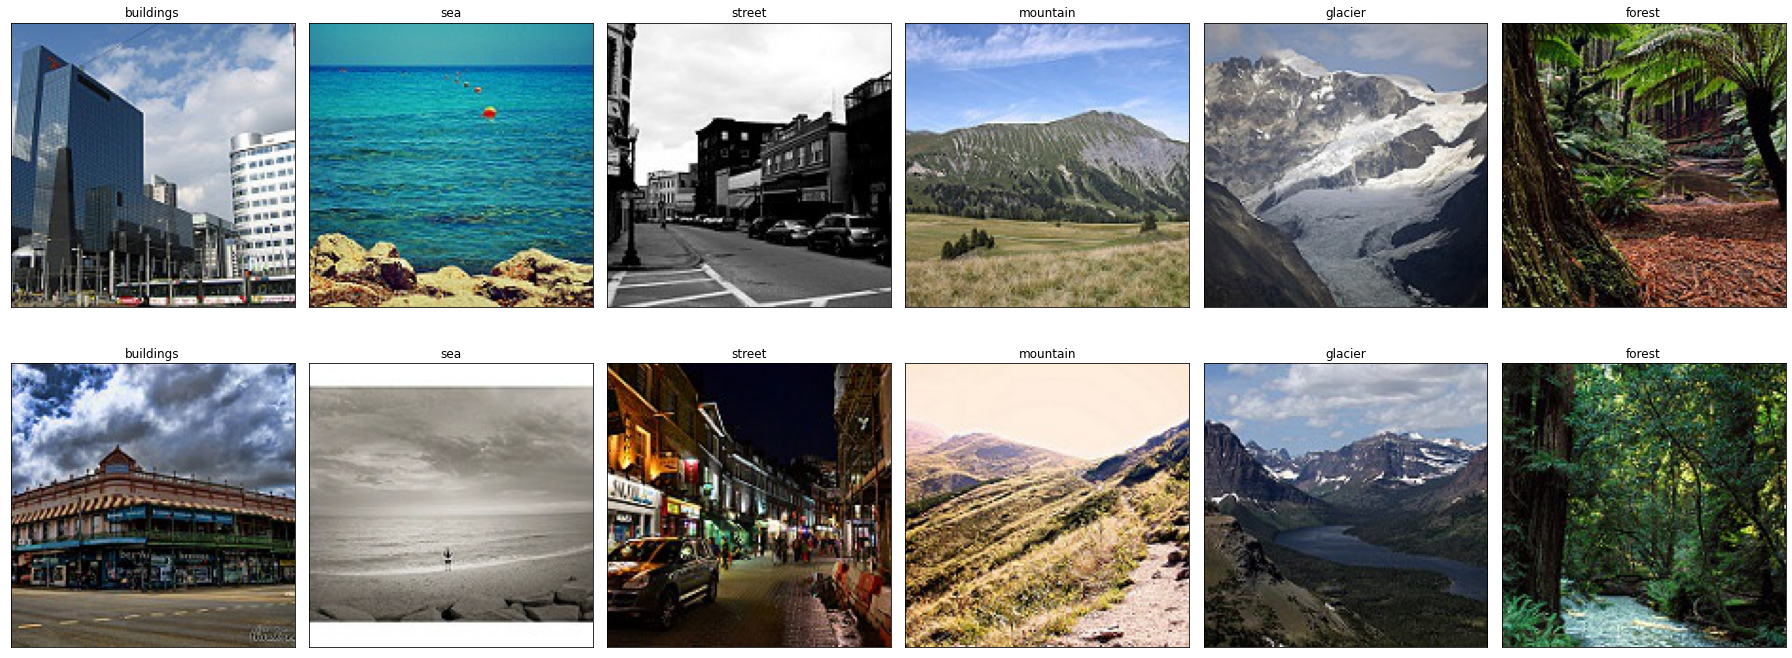

In [9]:
fig, axes = plt.subplots(2, len(scene_classes), figsize=(25, 10))
for i, (cls, files) in enumerate(scene_classes.items()):
    for j in range(2):
        first_image_path = choice(files)
        first_image = imread(first_image_path)
        axes[j][i].imshow(first_image)
        axes[j][i].set_title(cls)
        axes[j][i].axes.xaxis.set_visible(False)
        axes[j][i].axes.yaxis.set_visible(False)
fig.tight_layout()

Recall [0.96796339 0.98235294 0.87025948 0.88952381 0.8716094  0.99367089]
Precision [0.8562753  0.99011858 0.95824176 0.87617261 0.89757914 0.99157895]
Recall [0.96567506 0.98431373 0.91217565 0.87238095 0.86980108 0.9978903 ]
Precision [0.88469602 0.99209486 0.96008403 0.88076923 0.90583804 0.96530612]


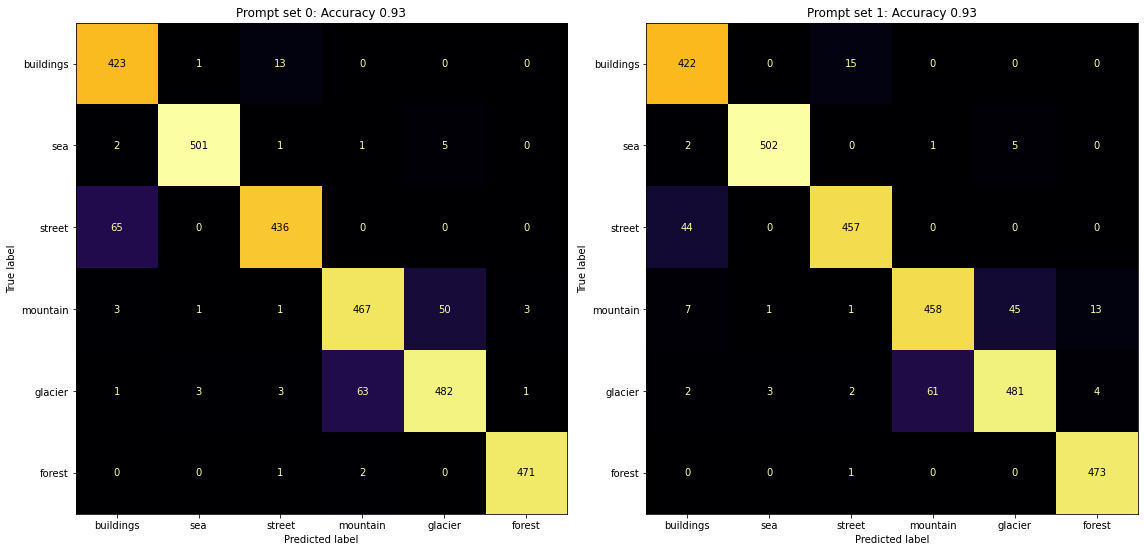

In [14]:
prompt_set = [[ cls for cls in scene_classes.keys()], ["a photo of a " + cls for cls in scene_classes.keys()]]
fig, axes = plt.subplots(1, len(prompt_set), figsize=(16, 8))
for idx, prompts in enumerate(prompt_set):
    preds, labels = evaluate_prompt_set_for_classes(model, processor, scene_classes, prompts, device)
    recall = recall_score(labels, preds, average=None)
    precision = precision_score(labels, preds, average=None)
    accuracy = accuracy_score(labels, preds)
    print("Recall", recall)
    print("Precision", precision)
    ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(scene_classes.keys()), ax=axes[idx], colorbar=False, cmap="inferno")
    axes[idx].set_title(f"Prompt set {idx}: Accuracy {accuracy:.2f}")
fig.tight_layout()

In [21]:
preds, labels = evaluate_prompt_set_for_classes(model, processor, scene_classes, prompt_set[1], device)

3000


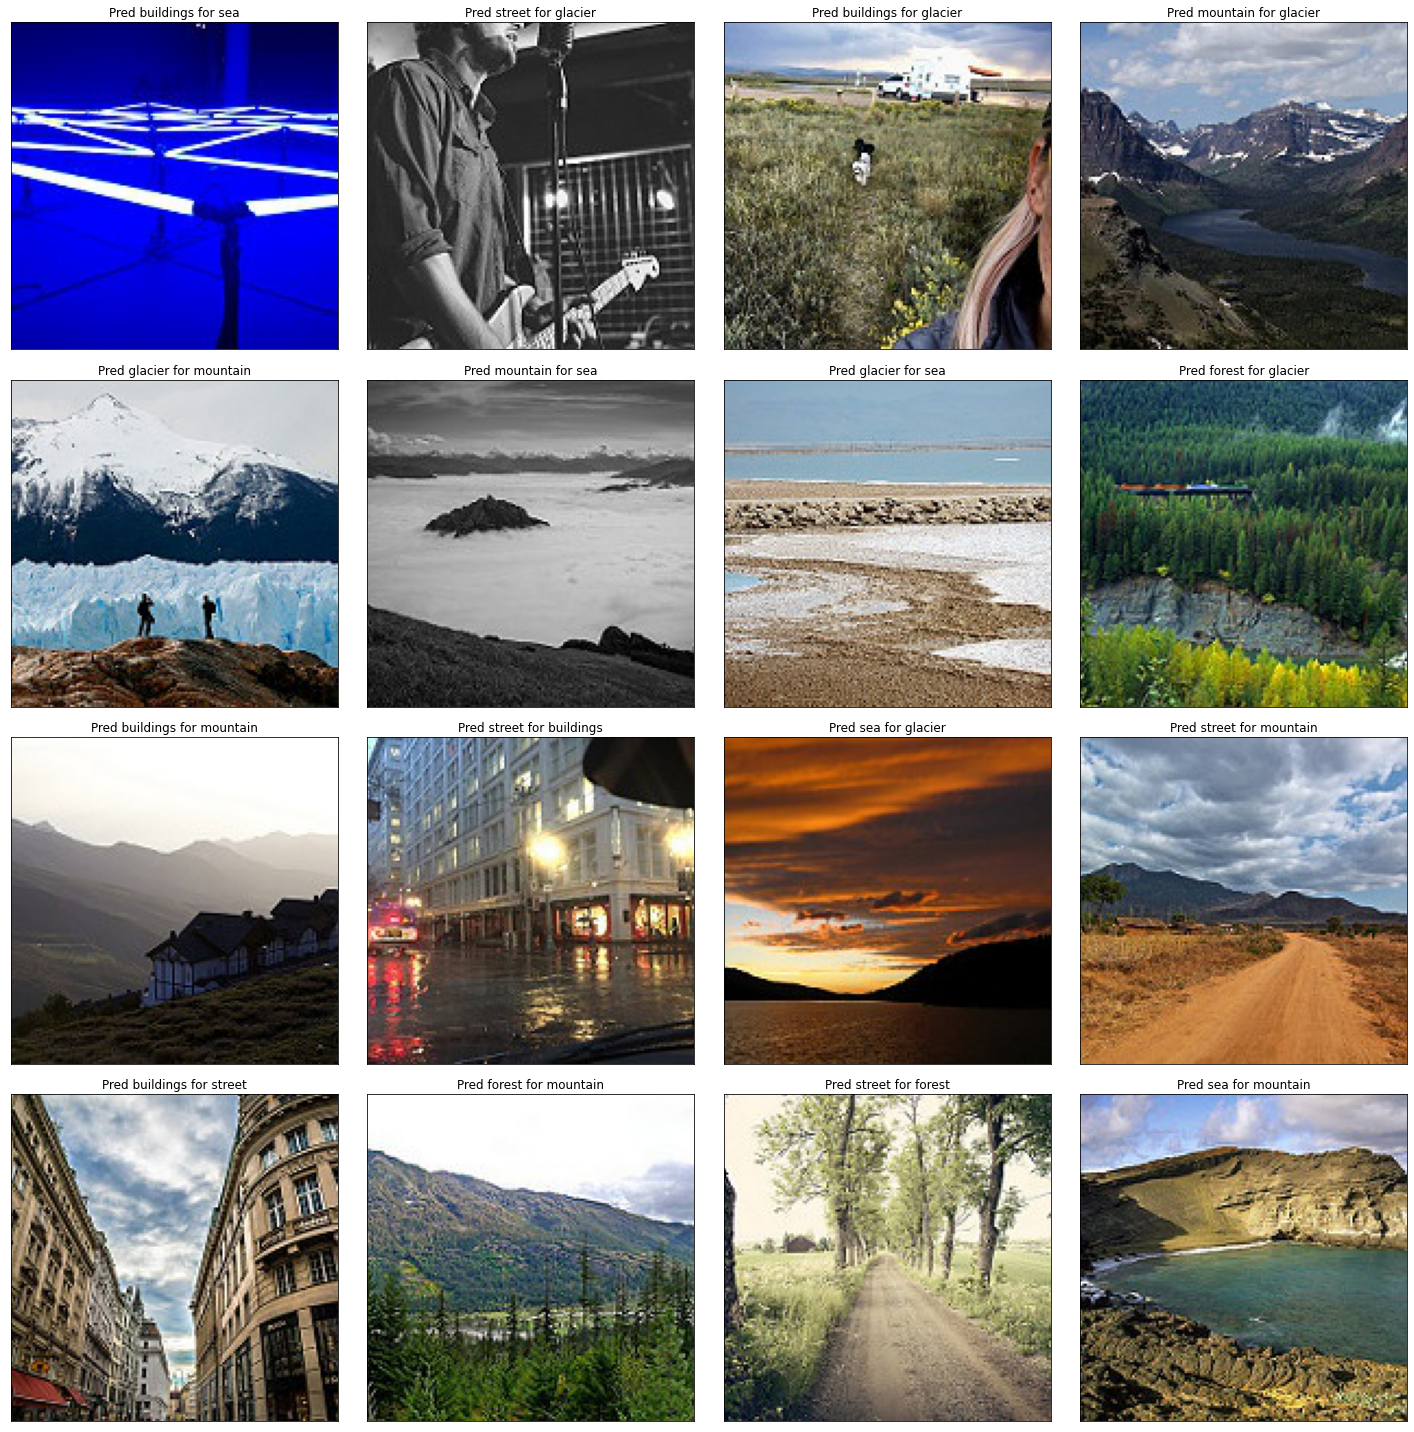

In [31]:
misclassified = set(zip(preds, labels)) - set(zip(range(len(scene_classes)), range(len(scene_classes))))
# This is janky, sorry
all = list(zip(preds, labels))
all_files = []
for files in scene_classes.values():
    all_files.extend(files)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
classes = list(scene_classes.keys())
for i, combo in enumerate(misclassified):
    row, col = i // 4, i%4
    idx = all.index(combo)
    pred, label = combo
    pred_cls, label_cls = classes[pred], classes[label]
    axes[row][col].imshow(Image.open(all_files[idx]))
    axes[row][col].set_title(f"Pred {pred_cls} for {label_cls}")
    axes[row][col].axes.xaxis.set_visible(False)
    axes[row][col].axes.yaxis.set_visible(False)
fig.tight_layout()

In [51]:
from utils.datasets import get_fruits_dataset

fruit_classes = get_fruits_dataset("test")
len(fruit_classes)

Checking for scene data in D:\Dropbox\Projects\clipsperiments\data\fruits.
Got 157 files for class apple.
Got 160 files for class apple_braeburn.
Got 159 files for class apple_crimson_snow.
Got 466 files for class apple_golden.
Got 160 files for class apple_granny_smith.
Got 234 files for class apple_hit.
Got 156 files for class apple_pink_lady.
Got 453 files for class apple_red.
Got 150 files for class apple_red_delicios.
Got 154 files for class apple_red_yellow.
Got 159 files for class apple_rotten.
Got 47 files for class cabbage_white.
Got 50 files for class carrot.
Got 131 files for class cucumber.
Got 80 files for class eggplant_violet.
Got 234 files for class pear.
Got 80 files for class zucchini.
Got 80 files for class zucchini_dark.


18

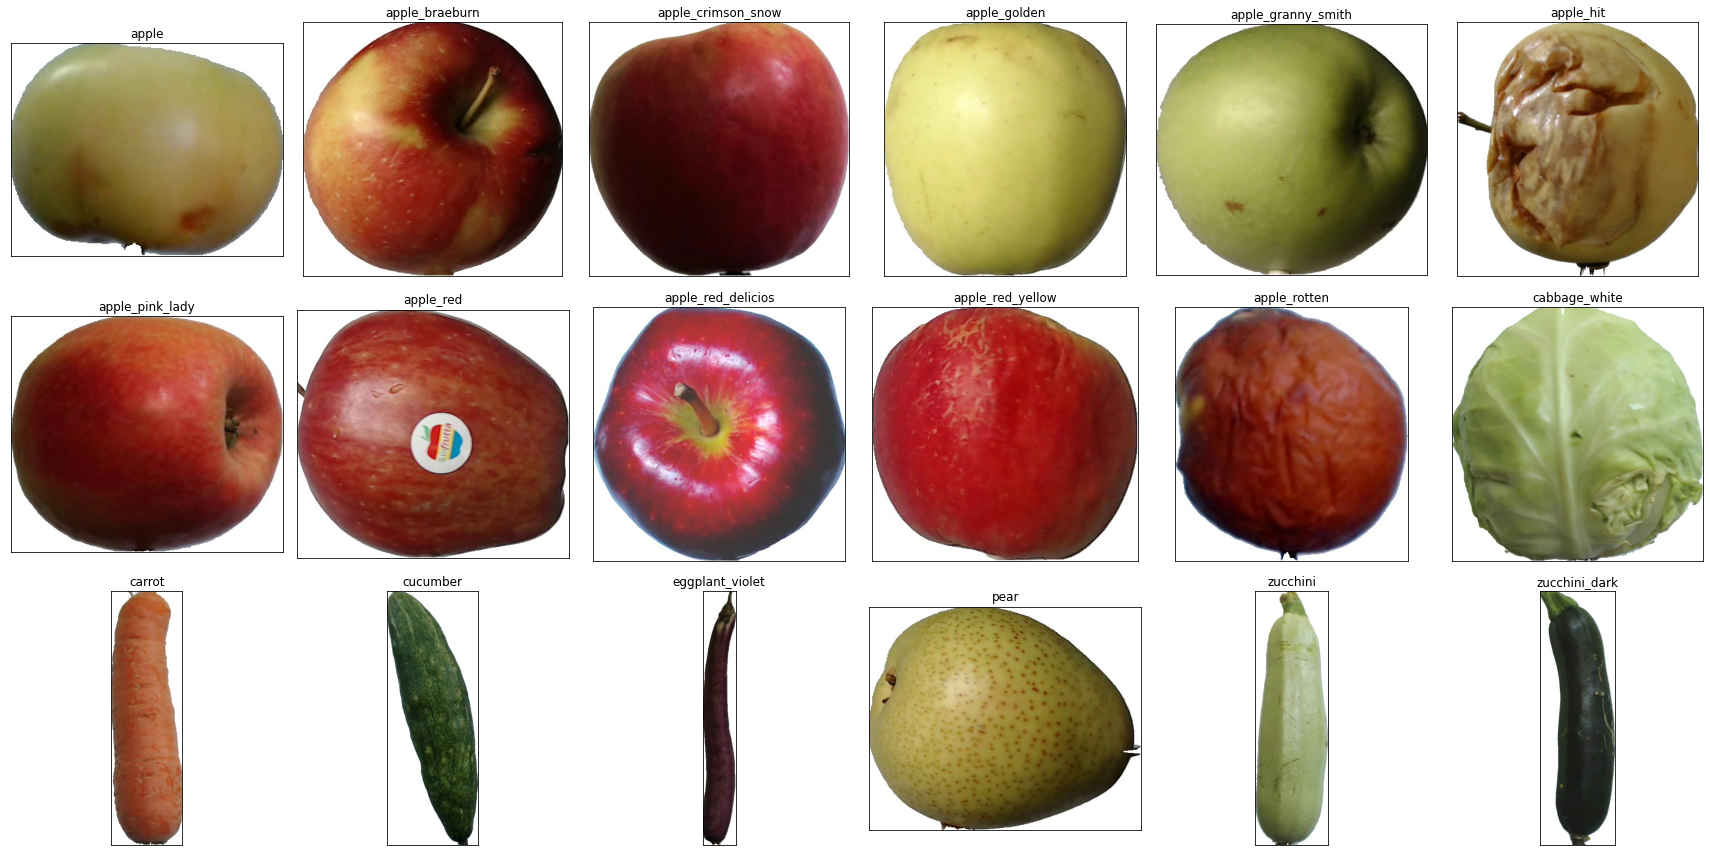

In [52]:
fig, axes = plt.subplots(3, 6, figsize=(24, 12))
classes = list(scene_classes.keys())
for i, (cls, files) in enumerate(fruit_classes.items()):
    row, col = i // 6, i%6
    ax = axes[row][col]
    first_image_path = choice(files)
    first_image = imread(first_image_path)
    ax.imshow(first_image)
    ax.set_title(cls)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
fig.tight_layout()

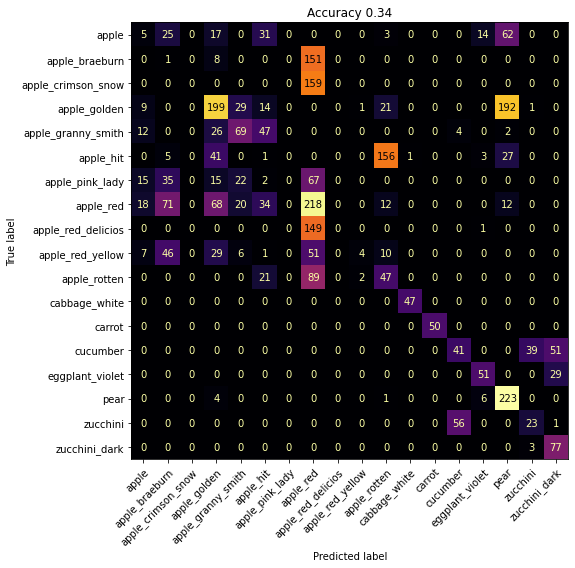

In [53]:
fig.tight_layout()
prompts = ["a photo of a " + cls for cls in fruit_classes.keys()]
fig, ax = plt.subplots(1, len(prompt_set), figsize=(16, 8))
preds, labels = evaluate_prompt_set_for_classes(model, processor, fruit_classes, prompts, device)
accuracy = accuracy_score(labels, preds)
ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(fruit_classes.keys()), ax=ax,
                                        colorbar=False, cmap="inferno")
ax.set_title(f"Accuracy {accuracy:.2f}")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()